# Otus Machine Learning Course. Homework №7

### Воротников Владимир

### Навигация
[1. Basic EDA](#1.-Basic-EDA)


[2. Building recomendation system](#2.-Building-recomendation-system)





In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

plt.rcParams["figure.figsize"] = [18, 8]\

## 1. Basic EDA

В качестве датасета использован датасет с рейтингами музыкальных композиций с Amazon ( https://nijianmo.github.io/amazon/index.html, а именно: http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz)

In [9]:
data = pd.read_json('data/Digital_Music_5.json', lines=True)

In [3]:
data.shape

(169781, 12)

In [4]:
data.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


Удаляем ненужные колонки, оставшиеся именуем интуитивно понятными названиями

In [11]:
data.drop(['vote', 'verified', 'reviewTime', 'style',
           'reviewerName', 'reviewText', 'summary', 'image', 'unixReviewTime'], axis=1, inplace=True)

In [12]:
data.rename(columns={"overall": "rating", 
                   "asin": "itemID"}, inplace=True)

In [13]:
data

,rating,reviewerID,itemID
0,5,A2TYZ821XXK2YZ,3426958910
1,5,A3OFSREZADFUDY,3426958910
2,5,A2VAMODP8M77NG,3426958910
3,4,AAKSLZ9IDTEH0,3426958910
4,5,A3OH43OZJLKI09,5557706259
...,...,...,...
169776,5,A1SR2T84IXOMAQ,B01HJ91MTW
169777,5,A2SR3DWJR1PYR6,B01HJ91MTW
169778,5,A24V7X30NIMOIY,B01HJ91MTW
169779,5,A1LW10GYP2EYM1,B01HJ91MTW


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   rating      169781 non-null  int64 
 1   reviewerID  169781 non-null  object
 2   itemID      169781 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [15]:
data.describe()

,rating
count,169781.000000
mean,4.700019
std,0.713420
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [16]:
data.nunique()

rating            5
reviewerID    16566
itemID        11797
dtype: int64

In [17]:
data.isnull().sum()

rating        0
reviewerID    0
itemID        0
dtype: int64

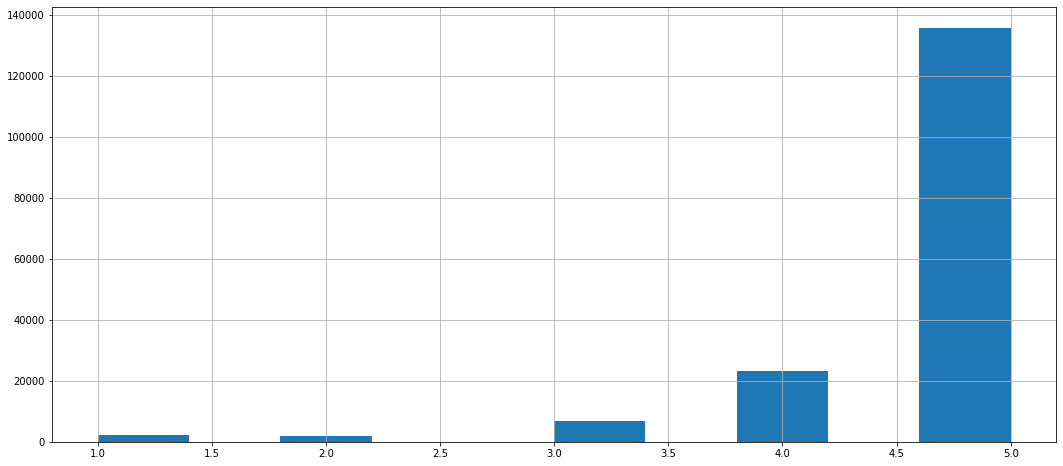

In [18]:
data.rating.hist()

In [19]:
data.rating.value_counts()

5    135842
4     23143
3      6792
1      2192
2      1812
Name: rating, dtype: int64

In [20]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

df = data.groupby('itemID')['rating'].count().clip(upper=50)

trace = go.Histogram(x = df.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
layout = go.Layout(title = 'Распределение рейтингов по композициям',
                   xaxis = dict(title = 'Число рейтингов по композиции'),
                   yaxis = dict(title = 'Количество'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [21]:
df = data.groupby('reviewerID')['rating'].count().clip(upper=50)

trace = go.Histogram(x = df.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
layout = go.Layout(title = 'Распределение рейтингов по юзерам',
                   xaxis = dict(title = 'Рейтинг по юзеру'),
                   yaxis = dict(title = 'Количество'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [22]:
min_book_ratings = 10
filter_books = data['itemID'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 10
filter_users = data['reviewerID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

print('The original data frame shape:\t{}'.format(data.shape))
data = data[(data['itemID'].isin(filter_books)) & (data['reviewerID'].isin(filter_users))]
print('The new data frame shape:\t{}'.format(data.shape))

The original data frame shape:	(169781, 3)
The new data frame shape:	(65636, 3)


## 2. Building recomendation system

In [23]:
reader = Reader(rating_scale=(1, 5))
data_new = Dataset.load_from_df(data[['reviewerID', 'itemID', 'rating']], reader)

In [24]:
import time
trainset, testset = train_test_split(data_new, test_size=0.25, random_state=37)
results = {}

for alg in [BaselineOnly(), KNNBasic(), SVD(), NMF()]:
    name = str(alg).split(' ')[0].split('.')[-1]
    
    start_time = time.time()
    predictions = alg.fit(trainset).test(testset)
    fit_test_time = time.time() - start_time
    
    acc = accuracy.rmse(predictions)
    
    results[name]=[fit_test_time,acc]

Estimating biases using als...
RMSE: 0.5755
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7128
RMSE: 0.5356
RMSE: 0.6451


In [26]:
d = pd.DataFrame.from_dict(results)
d.index = pd.Index(['time', 'rmse'])

In [27]:
display(d)

,BaselineOnly,KNNBasic,SVD,NMF
time,0.143633,0.624331,2.177198,2.616004
rmse,0.575456,0.712775,0.535583,0.645073


Без дополнительных настроек наилучшим образом с задачей справился SVD. При этом, если время обучения/предсказания критично, то можно использовать менее точные, но более быстрые варианты